In [7]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import datetime as dt
import seaborn as sb
sb.set()

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from itertools import product
from tqdm import tqdm_notebook
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("AAPL.csv",parse_dates=['Date'],index_col=['Date'])

In [9]:
df = df.loc[lambda x : x.index > dt.datetime(2012,12,31)]
size = int(len(df.values) * .8)
train,test = df[:size],df[size:len(df.values)]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.303900,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.207998,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.251616,458707200


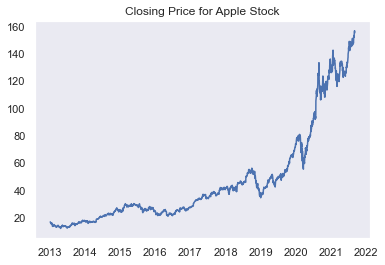

In [10]:
plt.plot(df.index,df['Adj Close'])
plt.title("Closing Price for Apple Stock")
plt.grid(False)
plt.show()

In [11]:
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving Average \n Window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label="Rolling Mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--',label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

        plt.plot(series[window:],label='Actual values')
        plt.legend(loc='best')
        plt.grid(True)

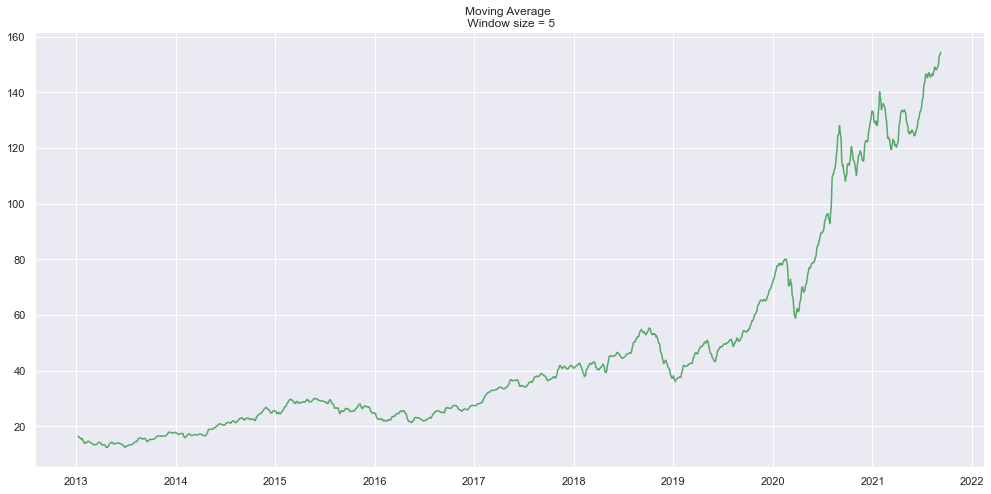

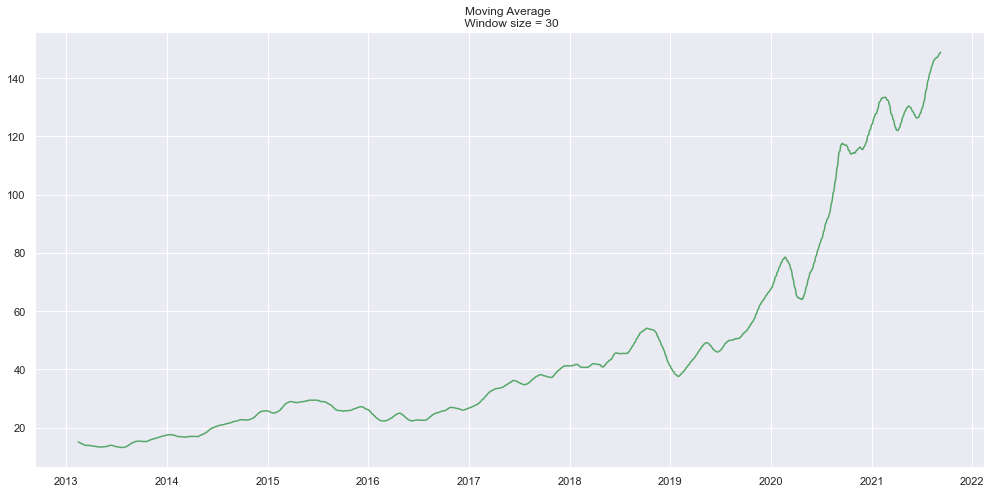

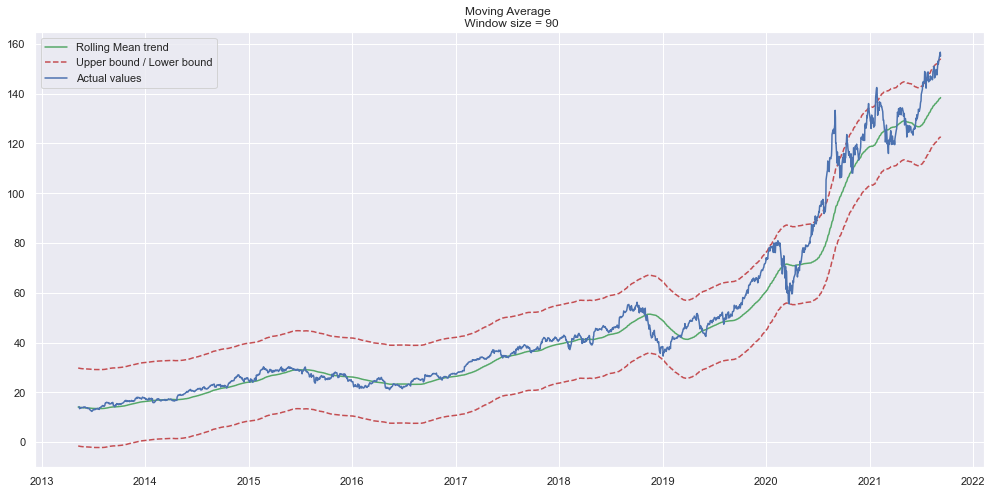

In [12]:
plot_moving_average(df['Adj Close'],5)

plot_moving_average(df['Adj Close'],30)

plot_moving_average(df['Adj Close'],90,plot_intervals=True)

In [13]:
def tsplot(y, lags=None, figsize=(12,7), style='bmh'):

    if not isinstance(y,pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))

        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Anaysis Plot \n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
        plt.tight_layout()

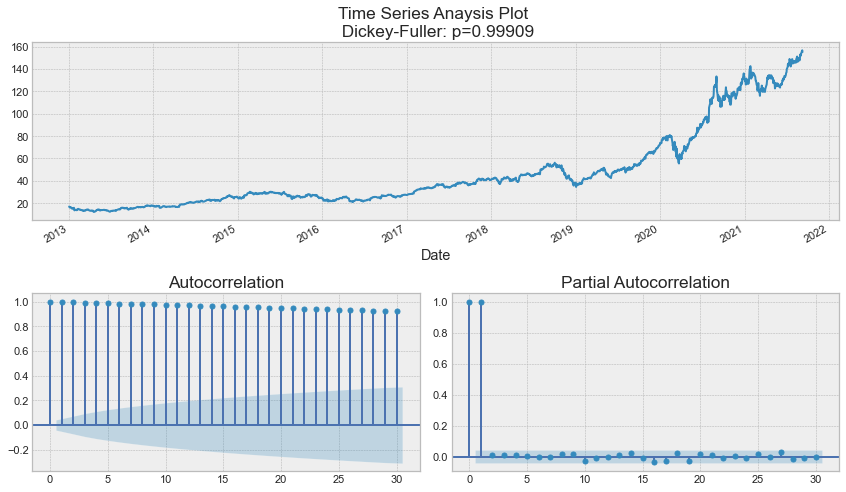

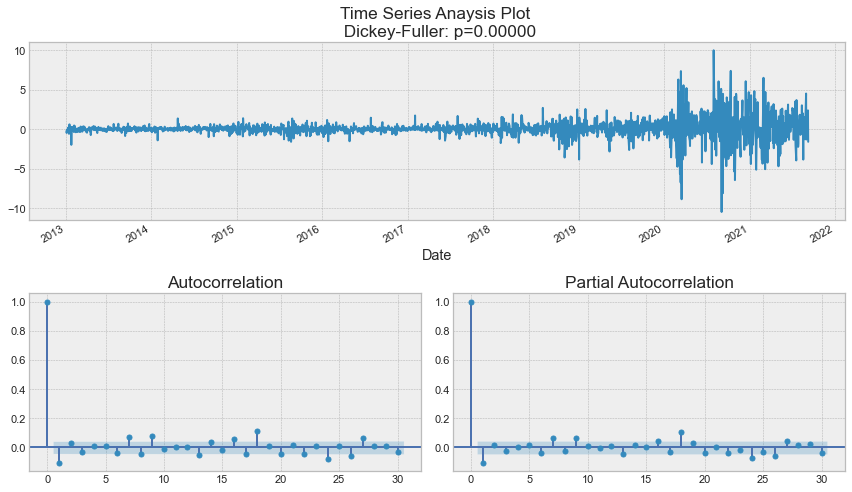

In [14]:
tsplot(df['Adj Close'],lags=30)

data_diff = df['Adj Close'] - df['Adj Close'].shift(1)

tsplot(data_diff[1:],lags=30)

### What does ARIMA(1, 0, 12) mean?
Specifically for your model, ARIMA(1, 0, 12) means that it you are describing some response variable (Y) by combining a 1st order Auto-Regressive model and a 12th order Moving Average model. A good way to think about it is (AR, I, MA). This makes your model look the following, in simple terms:

Y = (Auto-Regressive Parameters) + (Moving Average Parameters)

The 0 between the 1 and the 12 represents the 'I' part of the model (the Integrative part) and it signifies a model where you're taking the difference between response variable data - this can be done with non-stationary data and it doesn't seem like you're dealing with that, so you can just ignore it.


### What values can be assigned to p, d, q?
Lots of different whole numbers. There are diagnostic tests you can do to try to find the best values of p,d,q (see part 3).

### What is the process to find the values of p, d, q?
There are a number of ways, and I don't intend this to be exhaustive:

look at an autocorrelation graph of the data (will help if Moving Average (MA) model is appropriate)
look at a partial autocorrelation graph of the data (will help if AutoRegressive (AR) model is appropriate)
look at extended autocorrelation chart of the data (will help if a combination of AR and MA are needed)
try Akaike's Information Criterion (AIC) on a set of models and investigate the models with the lowest AIC values
try the Schwartz Bayesian Information Criterion (BIC) and investigate the models with the lowest BIC values
Without knowing how much more you need to know

* Edit: All of the ways to find p, d, q that I listed here can be found in the R package TSA if you are familiar with R.

AIC = -2/N * LL + 2 * k/N

BIC = -2 * LL + log(N) * k

MDL = L(h) + L(D | h)


Akaike’s Information Criteria generally tries to find unknown model that has high dimensional reality. On the other hand, the Bayesian Information Criteria comes across only True models.

Bayesian Information Criteria is consistent whereas Akaike’s Information Criteria is not so.

Akaike’s Information Criteria is good for making asymptotically equivalent to cross-validation. On the contrary, the Bayesian Information Criteria is good for consistent estimation.

Though BIC is more tolerant when compared to AIC, it shows less tolerance at higher numbers.

Unlike the AIC, the BIC penalizes free parameters more strongly.


In [15]:
ps = range(0,2)
d = 1
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)
s = 5

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

def optimize_ARIMA(parameters_list,d,D,s):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(df['Adj Close'],order=(param[0],d,param[1]),seasonal_order=(param[2],D,param[3],s)).fit()

        aic = model.aic

        if aic < best_aic:
            best_aic = aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters','aic'])
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

  0%|          | 0/16 [00:00<?, ?it/s]

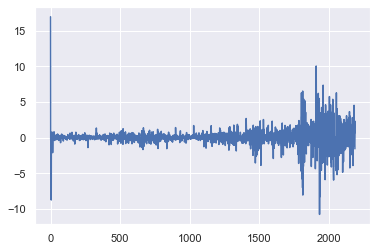

In [16]:
result_table = optimize_ARIMA(parameters_list,d,D,s)
p,q,P,Q = result_table.parameters[0]

best_model = ARIMA(df['Adj Close'],order=(p,d,q),seasonal_order=(P,D,Q,s)).fit()
arima_pred = best_model.predict()
plt.plot(best_model.resid.values)
market = 100 * df['Adj Close'].pct_change().dropna()
df['Return'] = market

In [18]:
rolling = pd.DataFrame(df['Return'], columns=['Return'])
print(rolling)
test_size = len(df.values)-size

for i in range(test_size):
    train = df['Return'][:-(test_size-i)].dropna()
    model = arch_model(train,p=1,q=1)
    model_fit = model.fit(disp="off")
    pred = model_fit.forecast(horizon=1)



              Return
Date                
2013-01-02       NaN
2013-01-03 -1.262222
2013-01-04 -2.785472
2013-01-07 -0.588215
2013-01-08  0.269114
...              ...
2021-09-01  0.447865
2021-09-02  0.747491
2021-09-03  0.423045
2021-09-07  1.548930
2021-09-08 -1.008361

[2187 rows x 1 columns]
